In [1]:
import numpy as np
import numpy.random as npr
npr.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import torch
torch.manual_seed(0)

%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

/home/gridsan/mmurphy/.conda/envs/HumanProteinAtlas/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Marker proteins of anatomical regions listed in "The kidney transcriptome and proteome defined by transcriptomics and antibody-based profiling".

In [2]:
TISSUE = 'kidney'
VERSION = 'final'
SAVEFIGS = True

In [3]:
hpa_markers = pd.read_csv(f'./data/{TISSUE}_labels.csv',index_col=0)
hpa_markers

,region,gene
Ensembl ID(supplied by Ensembl),,
ENSG00000128567,glomerulus,PODXL
ENSG00000158457,glomerulus,TSPAN33
ENSG00000113578,glomerulus,FGF1
ENSG00000116218,glomerulus,NPHS2
ENSG00000198743,glomerulus,SLC5A3
...,...,...
ENSG00000105707,collecting duct,HPN
ENSG00000214128,collecting duct,TMEM213
ENSG00000100362,collecting duct,PVALB


Our manual mapping of cell types in "Single cell transcriptional and chromatin accessibility profiling redefine cellular heterogeneity in the adult human kidney" to anatomical regions in "The kidney transcriptome and proteome defined by transcriptomics and antibody-based profiling".

In [4]:
hpa_mapping = pd.Series({
    'epithelial cell of proximal tubule':'proximal tubule',
    'fibroblast':None,
    'glomerular visceral epithelial cell':'glomerulus',
    'kidney capillary endothelial cell':'glomerulus',
    'kidney connecting tubule epithelial cell':'distal tubule',
    'kidney distal convoluted tubule epithelial cell':'distal tubule',
    'kidney loop of Henle thick ascending limb epithelial cell':'distal tubule',
    'leukocyte':None,
    'mesangial cell':'glomerulus',
    'parietal epithelial cell':'glomerulus',
    'renal alpha-intercalated cell':'collecting duct',
    'renal beta-intercalated cell':'collecting duct',
    'renal principal cell':'collecting duct'
},name='region')

Our method's per-image predictions. To permit evaluate we aggregate these first to antibody-level then to gene-level via averaging.

In [5]:
df = pd.read_csv('./data/hpa_v21_kidney.csv',index_col=0)

simclr_scores = pd.read_csv(f'./data/{TISSUE}_{VERSION}_scores.csv',index_col=0)
simclr_scores = ( simclr_scores.join(df[['Antibody','Gene']])
                               .groupby(['Antibody','Gene']).mean()
                               .groupby('Gene').mean() )
simclr_scores

,epithelial cell of proximal tubule,fibroblast,glomerular visceral epithelial cell,kidney capillary endothelial cell,kidney connecting tubule epithelial cell,kidney distal convoluted tubule epithelial cell,kidney loop of Henle thick ascending limb epithelial cell,leukocyte,mesangial cell,parietal epithelial cell,renal alpha-intercalated cell,renal beta-intercalated cell,renal principal cell
Gene,,,,,,,,,,,,,
ENSG00000000003,0.091052,0.072283,0.070970,0.069227,0.080865,0.076172,0.086828,0.070464,0.065138,0.074795,0.082506,0.079997,0.079702
ENSG00000000005,0.090986,0.075510,0.076042,0.078608,0.073513,0.069064,0.077664,0.080299,0.074179,0.078971,0.075295,0.075226,0.074642
ENSG00000000419,0.093640,0.070748,0.072687,0.073670,0.078487,0.073323,0.078604,0.077920,0.069898,0.077229,0.077295,0.076806,0.079695
ENSG00000000457,0.080171,0.074309,0.080793,0.074884,0.071592,0.069991,0.080265,0.089302,0.073891,0.081788,0.076657,0.072242,0.074115
ENSG00000000460,0.087218,0.073278,0.076363,0.073784,0.075304,0.073513,0.080744,0.074692,0.071843,0.080314,0.077366,0.079870,0.075709
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288607,0.081695,0.065820,0.109154,0.069710,0.072803,0.068789,0.078324,0.078565,0.064499,0.084855,0.079828,0.071204,0.074754
ENSG00000288616,0.081695,0.065820,0.109154,0.069710,0.072803,0.068789,0.078324,0.078565,0.064499,0.084855,0.079828,0.071204,0.074754
ENSG00000288631,0.081695,0.065820,0.109154,0.069710,0.072803,0.068789,0.078324,0.078565,0.064499,0.084855,0.079828,0.071204,0.074754


Simple baseline: one-versus-rest Wilcoxon tests on scRNA.

In [6]:
adata = sc.read('./data/local.h5ad')
sc.pp.filter_genes(adata,min_cells=1)
sc.pp.normalize_total(adata)
adata = adata[:,list(set(hpa_markers.index)&set(adata.var_names))].copy()

sc.tl.rank_genes_groups(adata,groupby='cell_type',method='wilcoxon',use_raw=False)
wilcoxon_scores = sc.get.rank_genes_groups_df(adata,group=None)
wilcoxon_scores = wilcoxon_scores.pivot(index='names',columns='group',values='scores')

sc.tl.rank_genes_groups(adata,groupby='cell_type',method='t-test',use_raw=False)
ttest_scores = sc.get.rank_genes_groups_df(adata,group=None)
ttest_scores = ttest_scores.pivot(index='names',columns='group',values='scores')
ttest_scores

group,epithelial cell of proximal tubule,fibroblast,glomerular visceral epithelial cell,kidney capillary endothelial cell,kidney connecting tubule epithelial cell,kidney distal convoluted tubule epithelial cell,kidney loop of Henle thick ascending limb epithelial cell,leukocyte,mesangial cell,parietal epithelial cell,renal alpha-intercalated cell,renal beta-intercalated cell,renal principal cell
names,,,,,,,,,,,,,
ENSG00000004948,-44.733444,-28.791033,-24.355230,-17.853590,-42.611668,29.655279,23.633970,-7.233623,-14.500906,-29.819168,-4.880006,-34.515076,-33.665054
ENSG00000007216,20.833302,-22.103024,-8.559255,-6.797849,-21.330557,-18.621908,-14.667913,-22.101055,-7.903287,-13.724620,-15.527706,-8.364832,-9.745852
ENSG00000008196,-41.162056,-14.920892,-21.081556,-20.165648,-14.665365,8.164674,34.825951,-48.299126,-19.830240,-23.501884,-28.518476,-16.587290,0.132820
ENSG00000010932,30.256937,-31.299704,-16.156851,-9.470925,-20.857422,-24.569416,-25.980495,-2.541900,-6.806368,-7.469543,-20.727667,-7.713006,-15.390405
ENSG00000015413,59.124695,-12.739351,-26.302553,-24.923491,-44.776329,-43.042603,-42.545475,-52.689510,-8.940749,-19.176580,-29.776266,-22.005070,-33.991062
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000204653,20.775036,-3.221577,-6.537712,-16.352375,-15.873324,-16.429007,-17.626879,-21.897408,-21.899754,-12.085157,-13.869867,-21.901239,-15.861681
ENSG00000214128,-48.792625,-6.602765,-17.699940,-22.850433,2.566607,24.898836,2.172393,-4.939250,-8.898575,-25.001682,25.069241,13.828671,-7.185124
ENSG00000235961,5.346296,-8.870846,0.718775,-5.068613,0.302918,-5.583587,-3.781314,-8.870720,-8.870874,-2.756822,-0.952535,-8.870972,-0.177415


Run "Comet": https://github.com/MSingerLab/COMETSC.

In [7]:
# !mkdir -p scratch
# subset = adata[:,list(set(hpa_markers.index)&set(adata.var_names))].copy()
# sc.pp.filter_cells(subset,min_counts=1) # Comet fails if there are empty cells

# subset.to_df().T.to_csv('scratch/comet_kidney_marker.tsv',sep='\t')
# # !touch scratch/comet_kidney_vis.tsv
# subset.obs['cell_type'].to_csv('scratch/comet_kidney_cluster.tsv',sep='\t',header=False)

# # !conda create -y --name comet python==3.6 && source activate comet && python -m pip install COMETSC
# num_cells, num_genes = subset.shape
# num_types = subset.obs['cell_type'].nunique()
# cutoff = 2/len(subset)
# trim = 2*num_genes
# args = f'-skipvis True -K'
# !source activate comet && Comet ./scratch/comet_kidney_marker.tsv ./scratch/comet_kidney_vis.tsv ./scratch/comet_kidney_cluster.tsv ./scratch/ {args}

In [8]:
comet_scores = {}
fns = !ls ./scratch/data/cluster_*_singleton_full_unranked.csv
for fn in fns:
    cluster = fn.split('_')[1]
    comet_scores[cluster] = 1-pd.read_csv(fn,index_col=0)['mHG_stat'].iloc[::2] # 1-x because we max-pool over regions
comet_scores = pd.DataFrame(comet_scores)
comet_scores

,epithelial cell of proximal tubule,fibroblast,glomerular visceral epithelial cell,kidney capillary endothelial cell,kidney connecting tubule epithelial cell,kidney distal convoluted tubule epithelial cell,kidney loop of Henle thick ascending limb epithelial cell,leukocyte,mesangial cell,parietal epithelial cell,renal alpha-intercalated cell,renal beta-intercalated cell,renal principal cell
gene_1,,,,,,,,,,,,,
ENSG00000004948,0.000000,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000007216,1.000000,0.0,0.0,0.0,0.000000,0.006311,0.053975,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000008196,0.000000,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000010932,1.000000,0.0,0.0,0.0,0.000000,0.000002,0.000018,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000015413,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000204653,1.000000,0.0,0.0,0.0,0.000000,0.032201,0.076639,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000214128,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.999999,0.0,0.0,0.0,1.0,0.0,0.0
ENSG00000235961,0.886504,0.0,0.0,0.0,0.120352,0.637796,0.749108,0.0,0.0,0.0,0.0,0.0,0.0


Aggregate per-cell-type scores into per-region scores.

In [9]:
true_regions = hpa_markers.reset_index().pivot(index=hpa_markers.index.name,columns='region')['gene']
true_regions = true_regions.fillna(0).astype(bool).astype(int)

# only compare markers detected in all three
# in principle this shouldn't be an issue: RNA detects ~33k genes, and proteins measured in previous HPA should be present in v21 too
true_regions = true_regions.loc[set(true_regions.index)&set(simclr_scores.index)&set(adata.var_names)]

def aggregate_regions(cell_type_scores, score_type):
    region_scores = cell_type_scores.T.join(hpa_mapping).groupby('region')
    if score_type=='probabilities':
        # marginalize
        region_scores = region_scores.sum().T
        region_scores.values[:] = region_scores.values / region_scores.sum(1).values[:,None]
    elif score_type=='test_statistics': 
        # logical OR over cell types within the region; assume higher test stat -> stronger signal
        region_scores = region_scores.max().T
    region_scores = region_scores.join(true_regions[[]],how='inner')
#     region_scores = region_scores.rank()
#     region_scores = platt_scaling(region_scores, true_regions)
    return region_scores

region_scores = {}
region_scores['Our method'] = aggregate_regions(simclr_scores,'probabilities')
region_scores['scRNA, Wilcoxon'] = aggregate_regions(wilcoxon_scores,'test_statistics')
region_scores['scRNA, T-test'] = aggregate_regions(ttest_scores,'test_statistics')
region_scores['scRNA, COMET'] = aggregate_regions(comet_scores,'test_statistics')

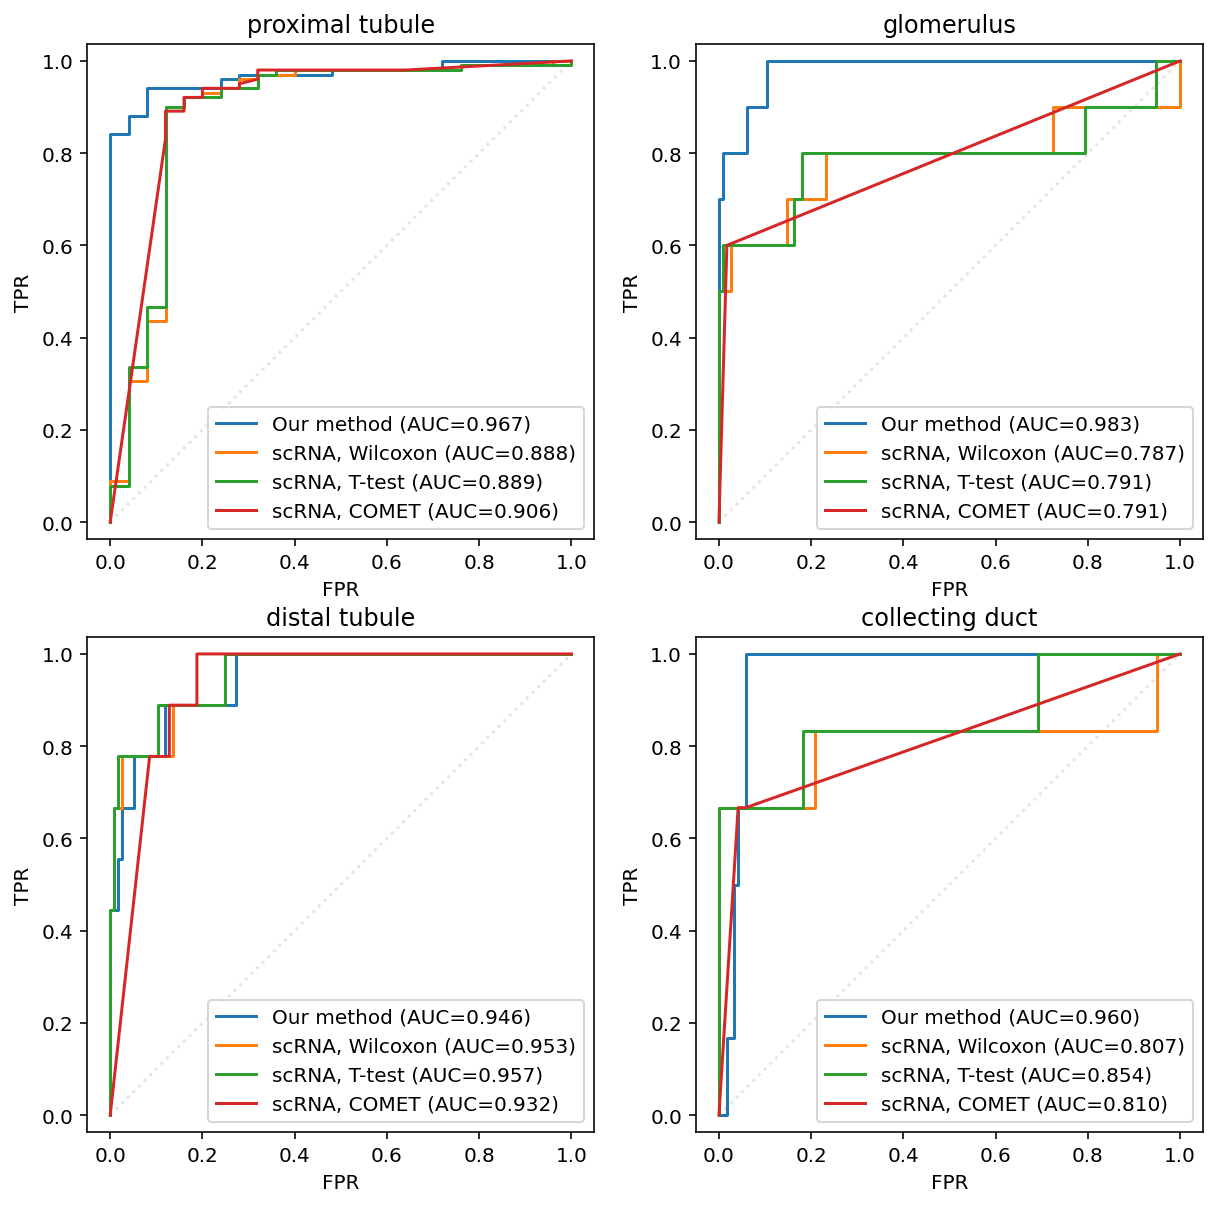

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score
from collections import defaultdict

regions = true_regions.sum().sort_values(ascending=False).index.tolist()

aucs = defaultdict(list)

def plot_roc(region_scores, ax, name, **kwargs):
    y = true_regions[region]
    y_pred = region_scores[region]
    idx = list(set(y.index)&set(y_pred.index))
    y, y_pred = y[idx], y_pred[idx]
    fpr, tpr, thr = roc_curve(y,y_pred)
    auc = roc_auc_score(y,y_pred)
    ax.plot(fpr,tpr,label=f'{name} (AUC=%.3f)'%auc, **kwargs)
    return auc

figsize = 5
fig,axs = plt.subplots(2,len(regions)//2,figsize=(len(regions)//2*figsize,2*figsize))
axs=axs.ravel()
for ax,region in zip(axs,regions):
    ax.plot([0,1],[0,1],'k:',alpha=0.1)
    ax.set_title(region)

    for method in region_scores:
        auc = plot_roc(region_scores[method], ax, method)
        aucs[method].append(auc)
    
    ax.axis('equal')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.legend()
    
if SAVEFIGS:
    plt.savefig(f'./figures/{TISSUE}_{VERSION}_roc.png', dpi=300);
else:
    plt.show();

In [11]:
aucs = pd.DataFrame(aucs,index=regions)
aucs.loc['overall'] = aucs.mean()
aucs.to_csv(f'./data/{TISSUE}_{VERSION}_aucs.csv')
aucs

,Our method,"scRNA, Wilcoxon","scRNA, T-test","scRNA, COMET"
proximal tubule,0.967129,0.887921,0.888713,0.905941
glomerulus,0.982759,0.787069,0.790517,0.791379
distal tubule,0.945869,0.952517,0.957265,0.931624
collecting duct,0.959722,0.806944,0.854167,0.809722
overall,0.963870,0.858613,0.872665,0.859667


In [12]:
deltas = (aucs['Our method'] - aucs.filter(like='scRNA').max(1)).rename('delta AUC').to_frame()
deltas['best baseline'] = aucs.filter(like='scRNA').idxmax(1)
deltas

,delta AUC,best baseline
proximal tubule,0.061188,"scRNA, COMET"
glomerulus,0.191379,"scRNA, COMET"
distal tubule,-0.011396,"scRNA, T-test"
collecting duct,0.105556,"scRNA, T-test"
overall,0.091204,"scRNA, T-test"


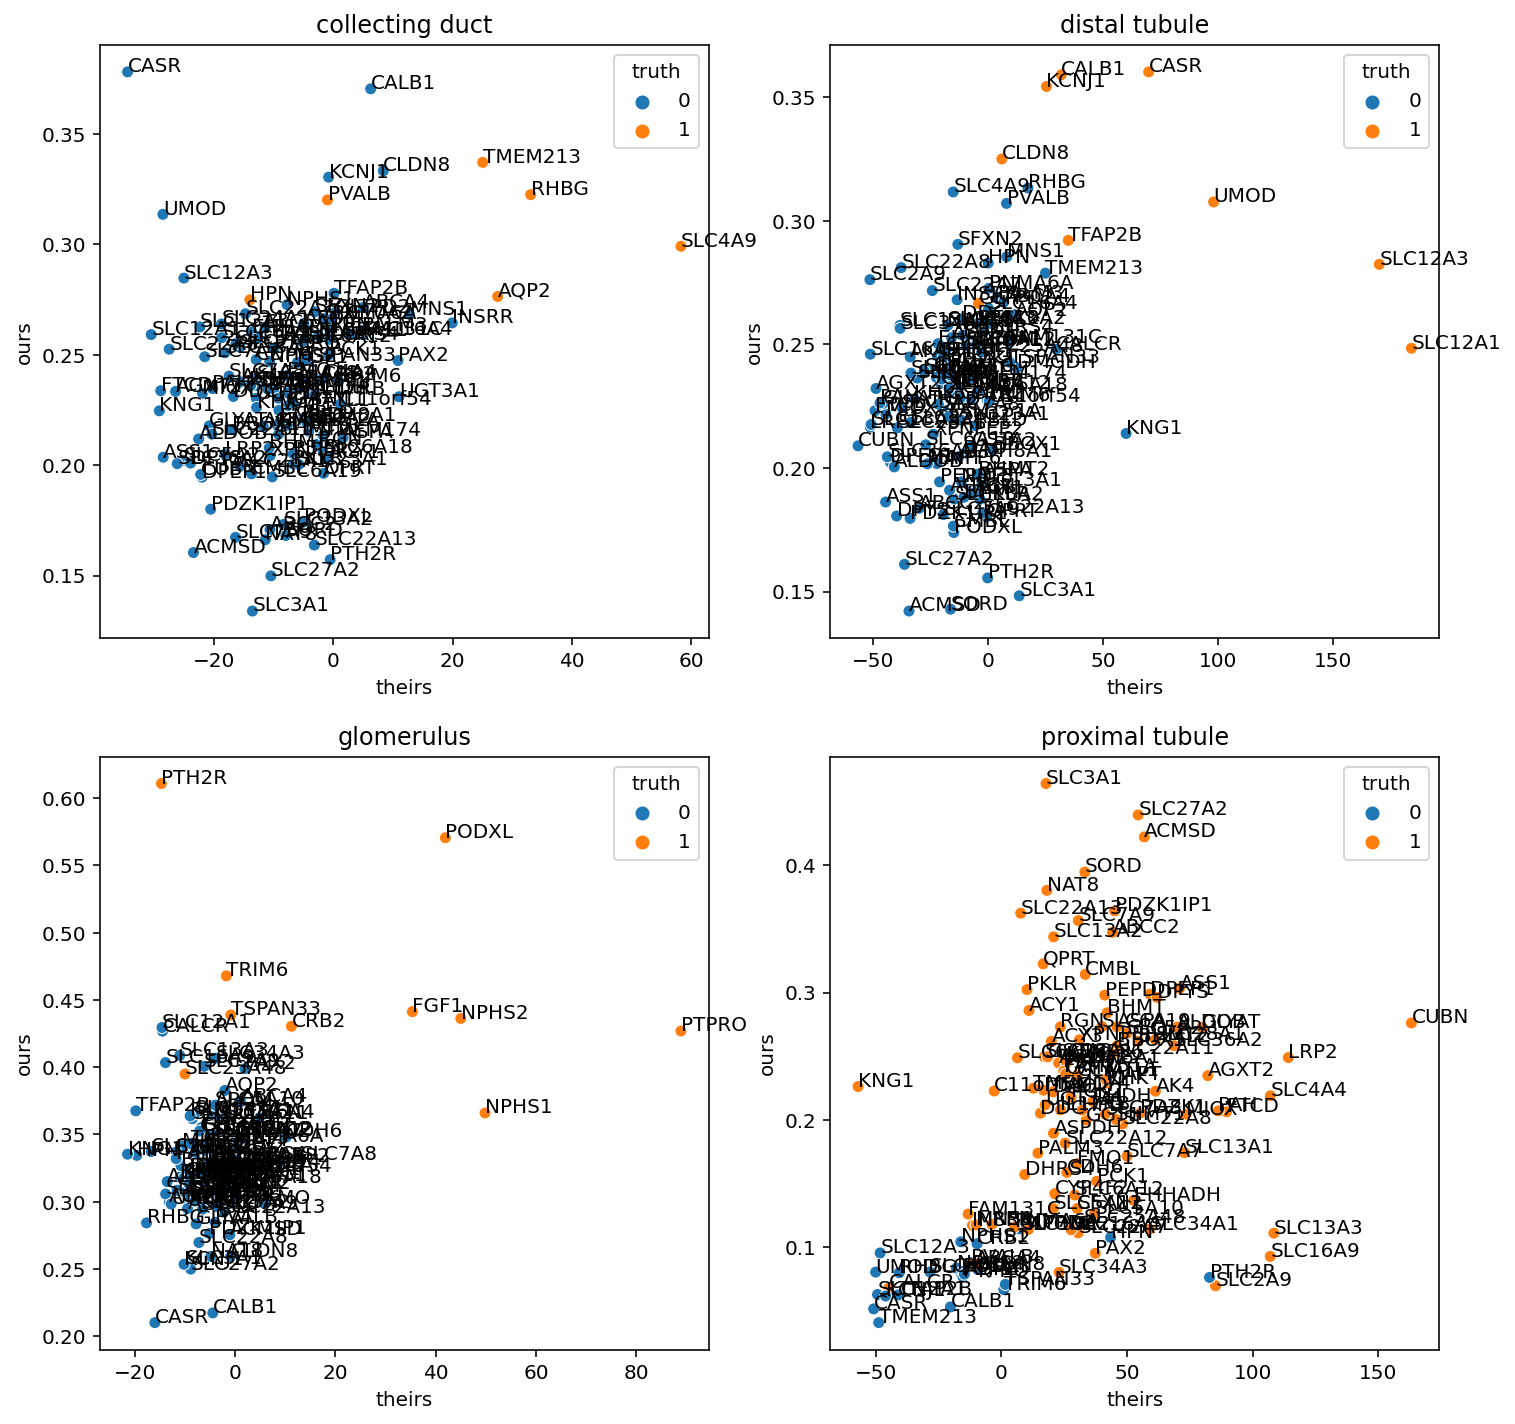

In [13]:
gene_names = df.set_index('Gene')['Gene name'].to_dict()
fig,axs=plt.subplots(2,2,figsize=(12,12))
axs=axs.ravel()
ours = 'Our method'
theirs = 'scRNA, T-test'
for i,region in enumerate(true_regions.columns):
    plt.sca(axs[i])
    data = region_scores[ours].join(region_scores[theirs], lsuffix='_ours', rsuffix='_theirs').join(true_regions, rsuffix='_true')
    data = data.filter(like=region).dropna()
    data.columns = ['ours','theirs','truth']
    sns.scatterplot(
        data=data,
        x='theirs',
        y='ours',
        hue='truth'
    )
    plt.title(region)
    for t, (x, y) in data[['theirs','ours']].iterrows():
        plt.text(x,y,gene_names[t])

# Case study

Case study - scores of selected genes.

In [14]:
# PTH2R, SLC2A9
region_scores['scRNA, T-test'].rank().loc[['ENSG00000144407','ENSG00000109667']]

region,collecting duct,distal tubule,glomerulus,proximal tubule
ENSG00000144407,106.0,99.0,7.0,118.0
ENSG00000109667,33.0,2.0,58.0,119.0


In [15]:
len(region_scores['scRNA, T-test'])

126

What are the antibodies?

In [16]:
scores = pd.read_csv(f'./data/{TISSUE}_{VERSION}_scores.csv',index_col=0)
scores = scores.T.join(hpa_mapping).groupby('region').sum().T
scores

region,collecting duct,distal tubule,glomerulus,proximal tubule
27133_A_8_5,0.222992,0.231646,0.294881,0.094160
27133_A_7_5,0.224806,0.241580,0.288141,0.094807
27133_A_9_5,0.216088,0.230499,0.299564,0.094015
2588_A_9_5,0.229539,0.224238,0.309058,0.081095
2588_A_8_5,0.223313,0.226406,0.311188,0.081897
...,...,...,...,...
24713_A_9_5,0.240881,0.276196,0.244619,0.123851
24713_A_7_5,0.218598,0.217118,0.294986,0.136989
26272_A_8_5,0.228697,0.224662,0.311317,0.078877
26272_A_9_5,0.219193,0.199661,0.348460,0.091501


In [17]:
# PTH2R: we predict glomerular marker (correctly)
df.query('Gene=="ENSG00000144407"').join(scores).groupby('Antibody').mean()

,Batch,Slide,nTPM,Age,Patient,collecting duct,distal tubule,glomerulus,proximal tubule
Antibody,,,,,,,,,
HPA010655,10655.0,26236.0,0.2,40.666667,2442.333333,0.116452,0.115211,0.452541,0.056626


In [18]:
# SLC2A9: we predict distal tubules (incorrectly)
df.query('Gene=="ENSG00000109667"').join(scores).groupby('Antibody').mean()

,Batch,Slide,nTPM,Age,Patient,collecting duct,distal tubule,glomerulus,proximal tubule
Antibody,,,,,,,,,
HPA066229,66229.0,150481.0,29.5,34.666667,2425.333333,0.212786,0.233821,0.328814,0.069815
HPA075669,75669.0,169761.0,29.5,63.333333,1992.000000,0.215200,0.232607,0.347670,0.048146


In [19]:
ab_scores = df.join(scores,how='inner').join(hpa_markers[[]],on='Gene',how='inner').groupby('Antibody').mean().rank()
len(ab_scores)

217

In [20]:
ab_scores.loc[['HPA010655']]

,Batch,Slide,nTPM,Age,Patient,collecting duct,distal tubule,glomerulus,proximal tubule
Antibody,,,,,,,,,
HPA010655,31.0,23.0,1.0,92.5,168.5,3.0,3.0,215.0,16.0


In [21]:
ab_scores.loc[['HPA066229']]

,Batch,Slide,nTPM,Age,Patient,collecting duct,distal tubule,glomerulus,proximal tubule
Antibody,,,,,,,,,
HPA066229,200.0,175.0,42.5,61.0,150.5,145.0,192.0,190.0,30.0


Case study - plot scRNA levels of selected genes.

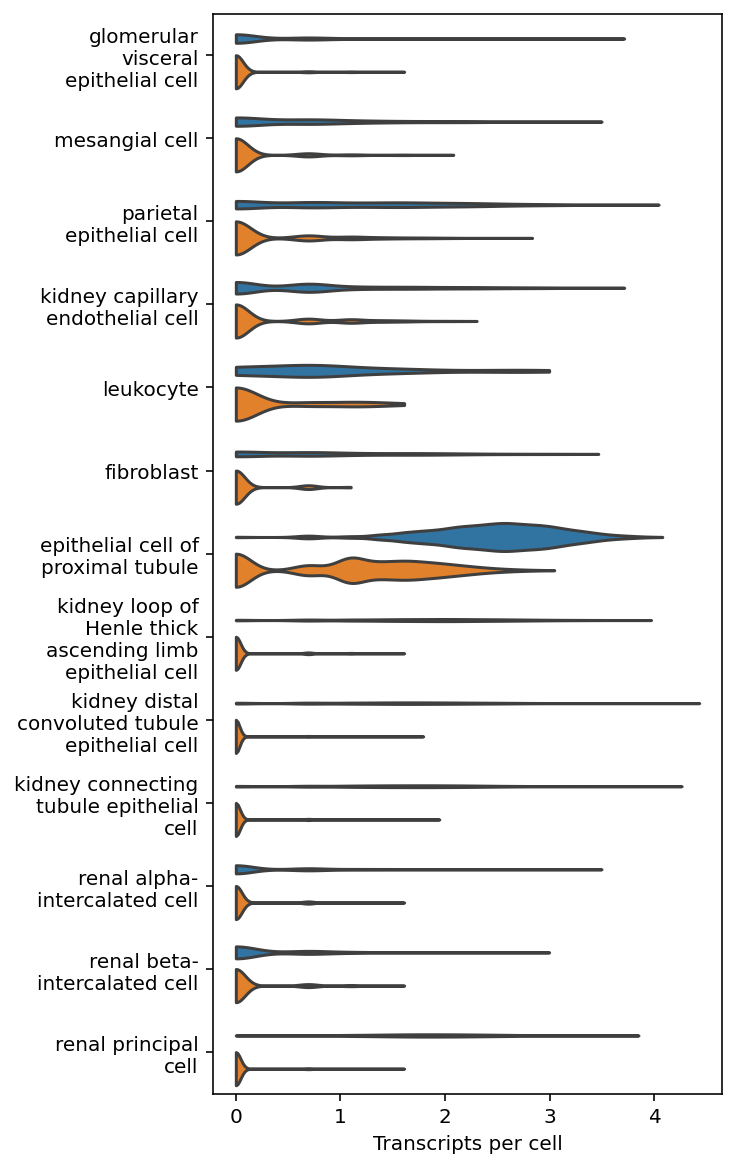

In [22]:
from figures.cell_type_colors import cell_type_colors
import textwrap

adata = sc.read(f'./data/local.h5ad')

data = adata[:,['ENSG00000144407','ENSG00000109667']].to_df()
data = data.melt(ignore_index=False)
data = data.join(adata.obs['cell_type'])
plt.figure(figsize=(5,8),constrained_layout=True)
sns.violinplot(
    data=data,
    y='cell_type',
    x='value',
    order=list(cell_type_colors[TISSUE]),
    hue='variable',
    inner=None,
    cut=0,
)
plt.gca().set_yticklabels([textwrap.fill(e.get_text(), 18) for e in plt.gca().get_yticklabels()]);
plt.gca().set_xlabel('Transcripts per cell')
plt.gca().set_ylabel('')
plt.legend([],[], frameon=False)
plt.savefig('./figures/rna.png', dpi=300)

In [23]:
# from figures.cell_type_colors import cell_type_colors

# scores = pd.read_csv(f'./data/{TISSUE}_{VERSION}_scores.csv',index_col=0)
# scores = adata.obs[[]].join(scores,how='left')

# adata.obs['pred_cell_type'] = scores.idxmax(1)
# adata.obs['pred_specificity'] = scores.max(1)
# adata.obs['pred_cell_type'] = ( adata.obs['pred_cell_type']
#                                     .astype('category')
#                                     .cat
#                                     .reorder_categories(list(cell_type_colors[TISSUE])) )

# fig, ax = plt.subplots(figsize=(10,10))
# sc.pl.umap(
#     adata, 
#     color=['pred_cell_type'], 
#     palette=cell_type_colors[TISSUE], 
#     ax=ax, 
#     s=adata.obs['pred_specificity']**2*1000,
#     na_in_legend=False,
#     show=False
# );